# 청와대 청원 주제 데이터


- train.csv / test.csv
index index
category 청원 주제/범주
data 청원 내용

- 라벨 종류
	0 : 인권/성평등

	1 : 문화/예술/체육/언론

	2 : 육아/교육



# 1.준비

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
import sentencepiece as spm
import tensorflow as tf
import urllib.request
import pandas as pd
import numpy as np
import csv
import re

In [3]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 53.4 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 4.44 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-03-21 10:42:57--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [4]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!tar -xzvf korean-english-park.train.tar.gz

--2022-03-21 10:47:26--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-03-21 10:47:27--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

# 2.데이터 정제

## 데이터 준비

In [126]:
import pandas as pd
import numpy as np
np.random.seed(456)
import re
from tqdm import tqdm # 진행률 표시
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
train_data = pd.read_csv("train.csv").iloc[:, 1:].dropna(how = 'any') # index 제거, NaN값이 1개만 있어도 drop
train_data.index = range(len(train_data))
# print(train_data.index) # RangeIndex(start=0, stop=39992, step=1)
test_data = pd.read_csv("test.csv").iloc[:, 1:] # index 제거
submission = pd.read_csv("sample_submission.csv")

display(train_data)
display(test_data)
display(submission)

train_data.shape, test_data.shape

,category,data
0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...
...,...,...
39987,2,시간유연근무제. 저는 국립대에서 일하고 있는 비정규직 근로자입니다.\n동시에 두 ...
39988,0,소년법을 폐지해 주시고 부산 여중생 가해자 학생들의 강력한 처벌을 요구합니다. 소년...
39989,2,무서운데 지켜야 할게 있어요 도와주세요. 안녕하세요 . 한부모엄마 입니다.\n양육비...
39990,2,교복에 고정식 이름표를 달게 하는 것을 금지해 주세요.. 교복에 이름표를 박아놓아...


,data
0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...
1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...
2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,국민위원에가 삼성편만들어요. 삼성에서 11년간 일하고 혈암과 백혈병 진단을 받은 ...
4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."
...,...
4995,페이스북 개인신상정보 개털렸는데 이대로... 존경하신 문재인 대통령님 ~!!\n얼마...
4996,아시안 게임에 야구프로스포츠 선수참여금지 청원합니다.. 뭐 대놓고 병역브로커 하자는...
4997,손흥민국가대표자격 영구박탈청원합니다. 광고찍을때랑 군면제걸렸을때 소속팀 토튼햄에서만...
4998,한진 사모님 이명희를 구속시키는 방안을 찿아보세요. 일단 밝혀진 피해자가 11명입니...


,index,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


((39992, 2), (5000, 1))

## 중복, 결측치, 불용어 제거

In [128]:
from konlpy.tag import Mecab
mecab = Mecab()

# 한글만 쓰자
train_data['data'] = train_data['data'].replace('[^ㄱ-ㅎ가-힣 ]', '')
test_data['data'] = test_data['data'].replace('[^ㄱ-ㅎ가-힣 ]', '')

# 중복 나가라
train_data.drop_duplicates(subset=['data'], inplace=True)
# test_data.drop_duplicates(subset=['data'], inplace=True)

# Nan 결측치는 사라져라
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')
print("train_data 결측치 확인 - ", train_data.isna().sum())
print("test_data 결측치 확인 - ", test_data.isna().sum())

display(train_data)
print()
display(test_data)
print(len(test_data))

train_data 결측치 확인 -  category    0
data        0
dtype: int64
test_data 결측치 확인 -  data    0
dtype: int64


,category,data
0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...
...,...,...
39987,2,시간유연근무제. 저는 국립대에서 일하고 있는 비정규직 근로자입니다.\n동시에 두 ...
39988,0,소년법을 폐지해 주시고 부산 여중생 가해자 학생들의 강력한 처벌을 요구합니다. 소년...
39989,2,무서운데 지켜야 할게 있어요 도와주세요. 안녕하세요 . 한부모엄마 입니다.\n양육비...
39990,2,교복에 고정식 이름표를 달게 하는 것을 금지해 주세요.. 교복에 이름표를 박아놓아...


,data
0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...
1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...
2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,국민위원에가 삼성편만들어요. 삼성에서 11년간 일하고 혈암과 백혈병 진단을 받은 ...
4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."
...,...
4995,페이스북 개인신상정보 개털렸는데 이대로... 존경하신 문재인 대통령님 ~!!\n얼마...
4996,아시안 게임에 야구프로스포츠 선수참여금지 청원합니다.. 뭐 대놓고 병역브로커 하자는...
4997,손흥민국가대표자격 영구박탈청원합니다. 광고찍을때랑 군면제걸렸을때 소속팀 토튼햄에서만...
4998,한진 사모님 이명희를 구속시키는 방안을 찿아보세요. 일단 밝혀진 피해자가 11명입니...


5000


# 3.SentencePieceProcessor

In [129]:
vocab_size = 10000
temp_file = 'korean-english-park.train.ko'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)
)

In [130]:
# vocab을 불러오기
vocab_list = pd.read_csv('korean_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.head(10)

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,.,-3.41161
4,▁,-3.51653
5,을,-3.86357
6,의,-3.92848
7,에,-4.28122
8,를,-4.28425
9,이,-4.35286


In [131]:
from konlpy.tag import Mecab
mecab = Mecab()

stop_df = pd.read_csv('한국어불용어100.txt', sep = '\t', header = None, names = ['형태','품사','비율'])
stop_df.tail()

,형태,품사,비율
95,원,NNB,0.000492
96,잘,MAG,0.000491
97,통하,VV,0.000487
98,소리,NNG,0.000486
99,놓,VX,0.000483


In [132]:
stopwords = stop_df.형태
type(stopwords)
stopwords_list = []
for i in stopwords:
    stopwords_list.append(str(i))
print(stopwords_list)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [133]:
sp = spm.SentencePieceProcessor()
sp.Load('korean_spm.model')

True

In [134]:
# # 불용어 제거 후 다시 널어주는 함수
# def clean_stopword(data, stopwords_list):
#     sentence_list = []
#     for sentence in data:
#         not_stopword = []
#         for word in sentence:
#             if word in stopwords_list:
#                 continue
#             elif word == ' ':
#                 continue
#             elif word == 'ㅋ':
#                 continue
#             else:
#                 not_stopword.append(word)
#         # print(not_stopword)
#         sentence_list.append(not_stopword)
#     print(sentence_list)
#     data = sentence_list

#     return sentence_list

# # 불용어 너도 나가
# sentence_train = clean_stopword(train_data['data'], stopwords_list)
# sentence_test = clean_stopword(test_data['data'], stopwords_list)

# # 빈 값 처리
# train_data['data'] = train_data['data'].replace('\\n', '')
# test_data['data'] = test_data['data'].replace('\\n', '')

# display(train_data)
# print()
# display(test_data)

In [135]:
ind_list = [24885, 14916, 14605, 6641, 17406, 26957, 2175, 6885, 8947, 14966, 8198, 25955, 39167,21707, 12678,
           3023, 31971, 3730, 37153, 33481, 33369, 12927, 30773, 36431,12373,  37525,27530, 8958, 16884, 18072,
           4478, 7940, 16400, 16656]
train_data = train_data.query('index not in @ind_list') 
train_data.index = range(0, len(train_data))

In [136]:
X_train = []

text = list(train_data['data'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords_list] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1] # 한 글자 뺴고 다 포함
  X_train.append(temp_X)
print(X_train)

100%|██████████| 39328/39328 [01:13<00:00, 537.33it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




In [137]:
X_test = []

text = list(test_data['data'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords_list] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_test.append(temp_X)
print(X_test)

100%|██████████| 5000/5000 [00:09<00:00, 523.22it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




In [138]:
print(len(X_train))

print(len(X_test))

39328
5000


In [139]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

In [140]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [141]:
threshold = 11
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 44451
등장 빈도가 10번 이하인 희귀 단어의 수: 31946
단어 집합에서 희귀 단어의 비율: 71.867899484826
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2553440928337687


In [142]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12506


In [143]:
tokenizer = Tokenizer(num_words = vocab_size) # 12506
tokenizer.fit_on_texts(X_train)

token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_test)

y_train = to_categorical(np.array(train_data['category']))

In [144]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [145]:
# 빈 샘플들을 제거
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = np.delete(y_train, drop_train, axis=0)
print(len(del_X_train))
print(len(del_y_train))

39301
39301


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [146]:
max_len = 300
pad_X_train = pad_sequences(del_X_train, maxlen = max_len)
pad_X_test = pad_sequences(token_X_test, maxlen = max_len)

In [147]:
len(pad_X_test)

5000

# 4.모델 설계

In [148]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 64, input_length = max_len))
model2.add(Conv1D(64, 5, activation = 'relu'))
model2.add(MaxPooling1D(5))
model2.add(Dropout(.5))
model2.add(Conv1D(64, 5, activation = 'relu'))
model2.add(GlobalMaxPooling1D())
model2.add(BatchNormalization())
model2.add(Dense(3, activation = 'softmax'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 64)           800384    
                                                                 
 conv1d_4 (Conv1D)           (None, 296, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 59, 64)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 59, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 55, 64)            20544     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                     

# 5.모델 훈련 및 검증

In [149]:
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

callback_ear = [EarlyStopping(monitor = 'val_loss',
                              patience = 2, mode = 'min', verbose = 1),
                ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_acc', save_best_only = True, mode = 'max',verbose = 1)]
history = model2.fit(pad_X_train, del_y_train, epochs = 50, batch_size = 64, verbose = 1, validation_split = 0.2, callbacks=callback_ear)

Epoch 1/50
491/492 [============================>.] - ETA: 0s - loss: 0.5123 - acc: 0.7834
Epoch 1: val_acc improved from -inf to 0.87393, saving model to best_model.h5
492/492 [==============================] - 8s 14ms/step - loss: 0.5123 - acc: 0.7834 - val_loss: 0.3984 - val_acc: 0.8739
Epoch 2/50
490/492 [============================>.] - ETA: 0s - loss: 0.2852 - acc: 0.8936
Epoch 2: val_acc did not improve from 0.87393
492/492 [==============================] - 7s 15ms/step - loss: 0.2851 - acc: 0.8937 - val_loss: 0.3370 - val_acc: 0.8716
Epoch 3/50
490/492 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9119
Epoch 3: val_acc did not improve from 0.87393
492/492 [==============================] - 7s 14ms/step - loss: 0.2260 - acc: 0.9121 - val_loss: 0.3705 - val_acc: 0.8630
Epoch 4/50
489/492 [============================>.] - ETA: 0s - loss: 0.1837 - acc: 0.9297
Epoch 4: val_acc did not improve from 0.87393
492/492 [==============================] - 7s 13ms/ste

## loss, accuracy 그래프 시각화

In [150]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [151]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

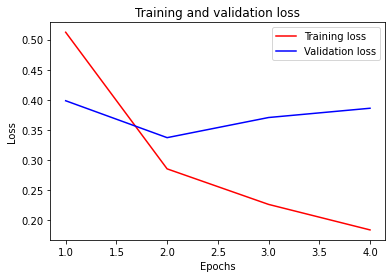

In [152]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

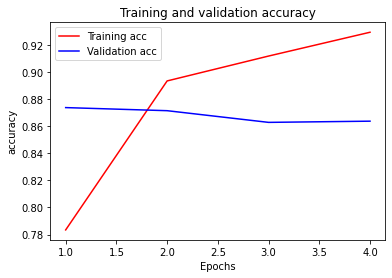

In [153]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 6.예측

In [154]:
pred = model2.predict(pad_X_test)
pred.shape

(5000, 3)

In [155]:
pred_list = []
for p in pred:
    # print(p)
    predict = np.argmax(p, axis = -1)
    pred_list.append(predict)
print(pred_list)

[2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 0, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0, 2, 0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 

In [164]:
submission['category'] = pred_list
submission

,index,category
0,0,2
1,1,2
2,2,1
3,3,1
4,4,2
...,...,...
4995,4995,0
4996,4996,1
4997,4997,1
4998,4998,0


In [165]:
submission.to_csv("result2.csv", index = False)

# 참고 사이트
- https://dacon.io/competitions/open/235597/codeshare/1737?page=1&dtype=recent